# Assessment of Renewable Energy Potentials based on Land Availability

The analysis of land availability for renewable energy potentials is divided into three stages. In this script, we will focus on the third stage: **Capacity and generation analysis**

-Goal: conduct analysis of power generation estimation, capacity, and capacity factor under three methods:
1. Capacity profile assumptions
2. Estimated hourly generation  

-Steps: Calculate the installed capacity and estimate the power generation for comparison:
1. Import data (data from stage 2, and data for three methods)
2. Setup assumptions based on data from stage 2 (whole country and regional division)
3. Method 1: Calculate the potentials capacity & annual generation via capacity profile assumptions<br>
(a) whole country<br>
(b) Regional division (under development) <br>
4. Method 2: Calculate the potentials capacity & annual generation via average hourly generation from 4 different cities<br>
(a) whole country<br>
(b) Regional division (under development) <br>

5. Comparison of different methods
**The analysis divides the available land areas (scenario 3 from stage 2) into 50% for utility solar PV and 50% for onshore wind farm planning.**

In [1]:
# import necessary library
# Set-up to have matplotlib use its support for notebook inline plots
%matplotlib inline
import matplotlib.pyplot as plt # Convention for import of the pyplot interface
from matplotlib.patches import Patch # for legend editing
from matplotlib.colors import BoundaryNorm
from matplotlib import rcParams, cycler
import os # operating system interfaces 
import datetime # time data sorting
import numpy as np # array and data sorting package
import pandas as pd # dataframe sorting package
import seaborn as sns # Use seaborn style defaults and set the default figure size
import geopandas # geospatial data processing package
import shapely.speedups # geospatial data speedup package

In [39]:
# Method 2 function: define function of time sorting (variables: input_df)
def time_sort(input_df):
    # reset time column into date time and select it as new index
    input_df.set_index('local_time')
    # add year, month and day name
    input_df['year'] = 2020
    input_df['month'] = pd.DatetimeIndex(input_df['local_time']).month
    input_df['day'] = pd.DatetimeIndex(input_df['local_time']).day
    input_df['hour'] = pd.DatetimeIndex(input_df['local_time']).hour
    # add last six hours back to beginning and replace the time stamp
    input_df['local_time'] = pd.to_datetime(input_df[['year', 'month', 'day', 'hour']])
    # sort by time
    input_df.sort_values(by=['local_time'], inplace = True)
    return input_df

In [46]:
# Method 2 function: define function of aonnual conversion (variables: output_df, input_df, capacity)
def method2_gen(output_df, input_df, capacity):
    # Using for loop to take mean value of all longtitudes and latitudes in each hour of the year
    for i in range(1, 13): # months from January to December
        for j in range(1,32): # day from 1 to 31 
            for k in range (0,24): # hours from 0 to 23
                select_df = input_df.loc[(input_df['month'] == i) & (input_df['day'] == j) & (input_df['hour'] == k) & (input_df['capacity'] == capacity)] # locate the hours 
                avg_time = select_df['local_time'].mean(axis = 0, skipna = True) # take mean value of the hour
                avg_gen = select_df['electricity'].mean(axis = 0, skipna = True) # take mean value of the hour
                
                output_df = output_df.append({'time': avg_time,'year': 2020,'month': i,'day': j,'hour': k,'hourly_generation[kWh]': avg_gen}, ignore_index=True) # add the values into new Dataframe
    # correct the value in time column from string into integer
    output_df['year'] = output_df['year'].astype(np.int64)
    output_df['month'] = output_df['month'].astype(np.int64)
    output_df['day'] = output_df['day'].astype(np.int64)
    output_df['hour'] = output_df['hour'].astype(np.int64)
    return output_df

## 1. Import data (data from stage 2, and data for method 2)

### a. Import the **land area** from the **result of stage 2**

In [33]:
land_gdf = pd.read_csv('Vietnam/02_output_stage2/02_vn_scenario3_al_ts_sl.csv') # Import final available land (from stgae 2)
sc3_wind_gdf = pd.read_csv('Vietnam/02_output_stage2/02_vn_scenario3_wind.csv') # Import result data of wind resources from stge 2
sc3_solar_gdf = pd.read_csv('Vietnam/02_output_stage2/02_vn_scenario3_solar.csv') # Import result data of solar resources from stge 2

### b. Import data for method 2

In [4]:
# Wind Speed and Solar Radiation data for Method 3
# Select the csv files from time-series folder
files = os.listdir('Vietnam/00_data_time_series/RenewablesNinja')    
files = list(filter(lambda f: f.endswith('.csv'), files))

# change directory to the generation data folder
#os.chdir('Users/yu-chi.chang/GIS_Land_VN/Vietnam/00_data_time_series/RenewablesNinja')
os.chdir('Vietnam/00_data_time_series/RenewablesNinja')
os.getcwd()

'c:\\Users\\yu-chi.chang\\GIS_Land_VN\\Vietnam\\00_data_time_series\\RenewablesNinja'

In [5]:
# corresponding cities and data
city_df = pd.read_excel('Cities.xlsx')
city = city_df['city']
city_lat = city_df['Lat']
city_long = city_df['Long']
city_types = city_df['Types']
city_cap = city_df['Capacity_PV_W_Wind_MW']

# Import first city to initiate the dataframe
# solar pv generation
pv_fileOne_df = pd.read_csv(files[0])
pv_fileOne_df['city']=city[0]
pv_fileOne_df['latitude']=city_lat[0]
pv_fileOne_df['longtitude']=city_long[0]
pv_fileOne_df['type']=city_types[0]
pv_fileOne_df['capacity']=city_cap[0]
pv_fileOne_df = pv_fileOne_df[['local_time', 'electricity', 'city', 'latitude', 'longtitude', 'type', 'capacity']]

# wind turbine generation
wt_fileOne_df = pd.read_csv(files[8])
wt_fileOne_df['city']=city[8]
wt_fileOne_df['latitude']=city_lat[8]
wt_fileOne_df['longtitude']=city_long[8]
wt_fileOne_df['type']=city_types[8]
wt_fileOne_df['capacity']=city_cap[8]
wt_fileOne_df = wt_fileOne_df[['local_time', 'electricity', 'city', 'latitude', 'longtitude', 'type', 'capacity']]

# put rest of three cities into the dataframe
# solar pv generation
for i in range(1, 8):
    pv_files_df = pd.read_csv(files[i])
    pv_files_df['city']=city[i]
    pv_files_df['latitude']=city_lat[i]
    pv_files_df['longtitude']=city_long[i]
    pv_files_df['type']=city_types[i]
    pv_files_df['capacity']=city_cap[i]
    pv_files_df = pv_files_df[['local_time', 'electricity', 'city', 'latitude', 'longtitude', 'type', 'capacity']]
    pv_fileOne_df = pv_fileOne_df.append(pv_files_df)

# wind turbine generation
for i in range(9, 16):
    wt_files_df = pd.read_csv(files[i])
    wt_files_df['city']=city[i]
    wt_files_df['latitude']=city_lat[i]
    wt_files_df['longtitude']=city_long[i]
    wt_files_df['type']=city_types[i]
    wt_files_df['capacity']=city_cap[i]
    wt_files_df = wt_files_df[['local_time', 'electricity', 'city', 'latitude', 'longtitude', 'type', 'capacity']]
    wt_fileOne_df = wt_fileOne_df.append(wt_files_df)
    
pv_fileOne_df.head()

,local_time,electricity,city,latitude,longtitude,type,capacity
0,01/01/2019 07:00,0.013,DaNang,16.068,108.212,PHOT,250.0
1,01/01/2019 08:00,0.032,DaNang,16.068,108.212,PHOT,250.0
2,01/01/2019 09:00,0.049,DaNang,16.068,108.212,PHOT,250.0
3,01/01/2019 10:00,0.064,DaNang,16.068,108.212,PHOT,250.0
4,01/01/2019 11:00,0.074,DaNang,16.068,108.212,PHOT,250.0


In [6]:
# change back to the original directory
os.chdir('../../..')
os.getcwd()

'c:\\Users\\yu-chi.chang\\GIS_Land_VN'

## 2. Setup assumptions based on data from stage 2 (whole country and regional division)

### a. Calculate the total land area

In [7]:
name = 'Vietnam'
land_sum = land_gdf['area_km2'].sum(axis = 0, skipna = True)
# Total areas in square kilometers
print('Total area of scenario 3 in', name, ':', land_sum,'km^2')

Total area of scenario 3 in Vietnam : 1609.2473186850455 km^2


### b. Divide the land area into different regions and Calculate the land area of different regions
The regions area defined based on https://en.wikipedia.org/wiki/List_of_regions_of_Vietnam

In [14]:
# separate into regions: Northeast, Northwest, Red River Delta, North Central Coast, South Central Coast, Central Highlands, Southeast, Mekong River Delta 
nw_arr = ['Dien Bien','Hoa Binh', 'Lai Chau', 'Lao Cai', 'Son La', 'Yen Bai'] 
ne_arr = ['Bac Giang','Bac Kann', 'Cao Bangu', 'Ha Giang', 'Lang Son', 'Phu Tho', 'Quang Ninh', 'Thai Nguyen', 'Tuyen Quang'] 
rrd_arr = ['Bac Ninh', 'Ha Nam', 'Ha Noi', 'Hai Duong', 'Hai Phong', 'Hung Yen', 'Nam Dinh', 'Ninh Binh', 'Thai Binh', 'Vinh Phuc'] 
ncc_arr = ['Ha Tinh', 'Nghe An', 'Quang Binh', 'Quang Tri', 'Thanh Hoa', 'Thua Thien Hue']
scc_arr = ['Binh Dinh', 'Binh Thuan', 'Da Nang', 'Khanh Hoa', 'Ninh Thuan', 'Phu Yen', 'Quang Nam', 'Quang Ngai']
ch_arr = ['Dak Lak', 'Dak Nong', 'Gia Lai', 'Kon Tum', 'Lam Dong']
se_arr = ['Ba Ria Vung Tau', 'Binh Duong', 'Binh Phuoc', 'Dong Nai', 'Saigon', 'Tay Ninh'] 
mrd_arr = ['An Giang', 'Ben Tre', 'Bac Lieu', 'Ca Mau', 'Can Tho City', 'Dong Thap', 'Hau Giang',
             'Kien Giang', 'Long An', 'Soc Trang', 'Tien Giang', 'Tra Vinh', 'Vinh Long']

region_name = ['Northwest', 'Northeast', 'Red River Delta', 'North Central Coast', 'South Central Coast', 'Central Highlands', 'Southeast', 'Mekong River Delta']
region_arr = [nw_arr, ne_arr, rrd_arr, ncc_arr, scc_arr, ch_arr, se_arr, mrd_arr]
region_dict = {} # empty dictionary
region_area_dict = {} # empty dictionary
for i in range(len(region_arr)):
    region_dict[region_name[i]] = land_gdf[land_gdf['ad_lv_1'].str.contains('|'.join(region_arr[i]))] # Northwest
    region_area_dict[region_name[i]] = region_dict[region_name[i]]['area_km2'].sum(axis = 0, skipna = True)

### d. Plot Graph of Available Land in Scenario3 of Different Regions

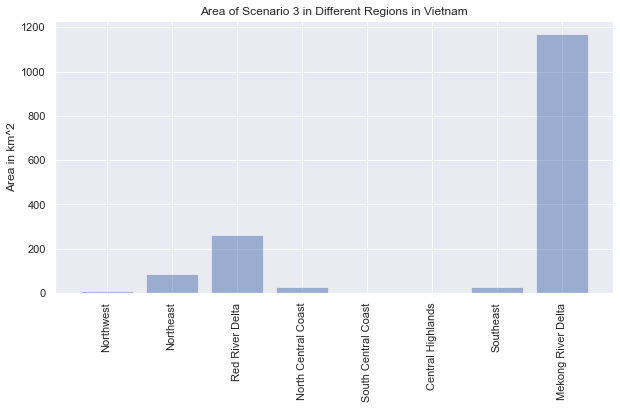

In [20]:
y_pos = np.arange(len(region_name))
sns.set(rc={'figure.figsize':(10,5)})

area_sum_arr = []
for i in range(len(region_arr)):
    area_sum_arr = np.append(area_sum_arr, region_area_dict[region_name[i]])

plt.bar(y_pos, area_sum_arr, align='center', alpha=0.5)
plt.xticks(y_pos, region_name, rotation='vertical')

plt.ylabel('Area in km^2')
plt.title('Area of Scenario 3 in Different Regions in Vietnam')
plt.savefig(r'Vietnam/03_output_stage3/03_area_scenario3_regions.tiff',bbox_inches='tight', dpi=300)
plt.show()

## 3. Method 1: Calculate the potentials capacity & annual generation via capacity profile assumptions
(a) whole country<br>
(b) Regional division (under development) <br>

**The analysis divides the available land areas (scenario 3 from stage 2) into 50% for utility solar PV and 50% for onshore wind farm planning.**

### a. HC/LC profile assumptions

In [21]:
# shares of utility solar pv and onshore wind farm
pv_sh = 0.5
wt_sh = 0.5

# wind HC/LC profile
wt_hc_c = 7.5 # capactiy of one wind turbine according to High Capacity (HC) Profile (7.5 MW)
wt_lc_c = 1 # capactiy of one wind turbine according to Low Capacity (LC) Profile (1 MW)
dia = 0.1 # rotor diameter (km)
wt_d = 4*dia*4*dia # distance between wind turbine: L*W = (5*rotor diameter)*(5*rotor diameter) (km2)

# solar HC/LC profile
pv_hc_c = 650 # capactiy of one PV panel according to High Capacity (HC) Profile (650 Wp) / Power Density (300 W/km2)
pv_hc_pd = 300
pv_lc_c = 250 # capactiy of one PV panel according to Low Capacity (LC) Profile (250 Wp)/ Power Density (50 W/km2)
pv_lc_pd = 50
pv_ef = 0.2 # efficiency factor of the PV modules: 20 (%)

### b. Calculation of capacity and generation

- Wind (Onshore): capacity factor (according to wind class IEC1-IEC3)

In [35]:
# potential capacity of HC/LC profile (GW) = (50% of land area * capacity of one wind turbine) / (distance between wind turbines * 1000)
wt_pc_lc = land_sum*wt_sh*wt_lc_c/wt_d/1000
wt_pc_hc = land_sum*wt_sh*wt_hc_c/wt_d/1000

# average capacity factor of a region according to wind class IEC1-IEC3
wt_cf1_sum = sc3_wind_gdf['capacity_factor_iec1'].mean(axis = 0, skipna = True)
wt_cf2_sum = sc3_wind_gdf['capacity_factor_iec2'].mean(axis = 0, skipna = True)
wt_cf3_sum = sc3_wind_gdf['capacity_factor_iec3'].mean(axis = 0, skipna = True)

# oneshore windfarm estimated annual generation of HC/LC profile (TWh) = (potential capacity * capactiy factor * 8760 hours) / 1000
wt_ag_cf1_lc = wt_pc_lc*wt_cf1_sum*8760/1000
wt_ag_cf2_lc = wt_pc_lc*wt_cf2_sum*8760/1000
wt_ag_cf3_lc = wt_pc_lc*wt_cf3_sum*8760/1000
wt_ag_cf1_hc = wt_pc_hc*wt_cf1_sum*8760/1000
wt_ag_cf2_hc = wt_pc_hc*wt_cf2_sum*8760/1000
wt_ag_cf3_hc = wt_pc_hc*wt_cf3_sum*8760/1000
print('Method 1 Capacity Profile (LC/HC)',
      '\nOnshore wind potential capacity of scenario 3 in', name, ':', '\n (1) LC Profile:', wt_pc_lc,'GW', '\n (2) HC Profile:', wt_pc_hc,'GW',
      '\nOnshore windfarm estimated annual generation of scenario 3 in', name, ':', 
      '\n (1) LC Profile in wind class IEC1:', wt_ag_cf1_lc,'TWh', 
      '\n (2) LC Profile in wind class IEC2:', wt_ag_cf2_lc,'TWh', 
      '\n (3) LC Profile in wind class IEC3:', wt_ag_cf3_lc,'TWh', 
      '\n (4) HC Profile in wind class IEC1:', wt_ag_cf1_hc,'TWh', 
      '\n (5) HC Profile in wind class IEC2:', wt_ag_cf2_hc,'TWh',
      '\n (6) HC Profile in wind class IEC3:', wt_ag_cf3_hc,'TWh',
      '\nOnshore windfarm capacity factor of scenario 3 in', name, ':', 
      '\n (1) Profiles in wind class IEC1:', wt_cf1_sum, 
      '\n (2) Profiles in wind class IEC2:', wt_cf2_sum,
      '\n (3) Profiles in wind class IEC3:', wt_cf3_sum)

Method 1 Capacity Profile (LC/HC) 
Onshore wind potential capacity of scenario 3 in Vietnam : 
 (1) LC Profile: 5.028897870890766 GW 
 (2) HC Profile: 37.716734031680744 GW 
Onshore windfarm estimated annual generation of scenario 3 in Vietnam : 
 (1) LC Profile in wind class IEC1: 7.1786954690889955 TWh 
 (2) LC Profile in wind class IEC2: 8.869024584902125 TWh 
 (3) LC Profile in wind class IEC3: 10.163546842881116 TWh 
 (4) HC Profile in wind class IEC1: 53.84021601816745 TWh 
 (5) HC Profile in wind class IEC2: 66.51768438676594 TWh 
 (6) HC Profile in wind class IEC3: 76.22660132160837 TWh 
Onshore windfarm capacity factor of scenario 3 in Vietnam : 
 (1) Profiles in wind class IEC1: 0.16295534432824427 
 (2) Profiles in wind class IEC2: 0.20132556970992366 
 (3) Profiles in wind class IEC3: 0.23071103691603054


- Solar (Utiliy-scale PV): PVOUT (power density, GWh/GWp)

In [36]:
# potential capacity of HC/LC profile (GW) = (50% of land area * power density of one PV panel) / 1000
pv_pc_lc = land_sum*pv_sh*pv_lc_pd/1000
pv_pc_hc = land_sum*pv_sh*pv_hc_pd/1000

# average power density of PV (PVOUT)
pv_out_sum = sc3_solar_gdf['pvout_kWh/kWp'].mean(axis = 0, skipna = True)

# Utility-Scale PV estimated annual generation of HC/LC profile (TWh) = (potential capacity * PVOUT) / 1000
pv_ag_lc = pv_pc_lc*pv_out_sum/1000
pv_ag_hc = pv_pc_hc*pv_out_sum/1000

# capacity factor
pv_ag_lc_cf = pv_ag_lc*10**3/(pv_pc_lc*8760)
pv_ag_hc_cf = pv_ag_hc*10**3/(pv_pc_hc*8760)

print('Method 1 Capacity Profile (LC/HC)',
    '\nUtility-Scale PV potential capacity of scenario 3 in', name, ':', '\n (1) LC Profile:', pv_pc_lc,'GW', '\n (2) HC Profile:', pv_pc_hc,'GW',
      '\nUtility-Scale PV estimated annual generation of scenario 3 in', name, ':', 
      '\n (1) LC Profile:', pv_ag_lc,'TWh', 
      '\n (2) HC Profile:', pv_ag_hc,'TWh',
      '\nUtility-Scale PV capacity factor of scenario 3 in', name, ':', 
      '\n (1) LC Profile:', pv_ag_lc_cf, 
      '\n (2) HC Profile:', pv_ag_hc_cf)

Method 1 Capacity Profile (LC/HC) 
Utility-Scale PV potential capacity of scenario 3 in Vietnam : 
 (1) LC Profile: 40.23118296712614 GW 
 (2) HC Profile: 241.3870978027568 GW 
Utility-Scale PV estimated annual generation of scenario 3 in Vietnam : 
 (1) LC Profile: 52.40737504298731 TWh 
 (2) HC Profile: 314.44425025792384 TWh 
Utility-Scale PV capacity factor of scenario 3 in Vietnam : 
 (1) LC Profile: 0.14870497505853245 
 (2) HC Profile: 0.14870497505853245


### c. Plot Graph of Potential Capacity in Scenario3 of Different Profiles

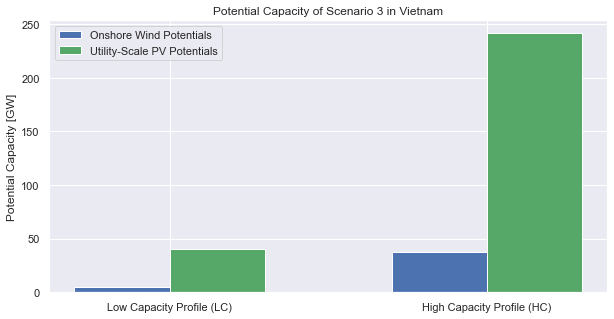

In [37]:
cap_arr = ['Low Capacity Profile (LC)', 'High Capacity Profile (HC)']
y_pos = np.arange(len(cap_arr))
wt_cap_arr = [wt_pc_lc, wt_pc_hc]
pv_cap_arr = [pv_pc_lc, pv_pc_hc]
bar_width = 0.35

sns.set(rc={'figure.figsize':(10,5)})
wt_rects = plt.bar(y_pos - 0.15, wt_cap_arr, width= 0.3,  color='b', label='Onshore Wind Potentials')
pv_rects = plt.bar(y_pos + 0.15, pv_cap_arr, width=0.3,  color='g', label='Utility-Scale PV Potentials')
plt.xticks(y_pos, cap_arr)
plt.ylabel('Potential Capacity [GW]')
plt.title('Potential Capacity of Scenario 3 in Vietnam')
plt.savefig(r'Vietnam/03_output_stage3/03_capacity_scenario3_method1.tiff',bbox_inches='tight', dpi=300)
plt.legend()
plt.show()

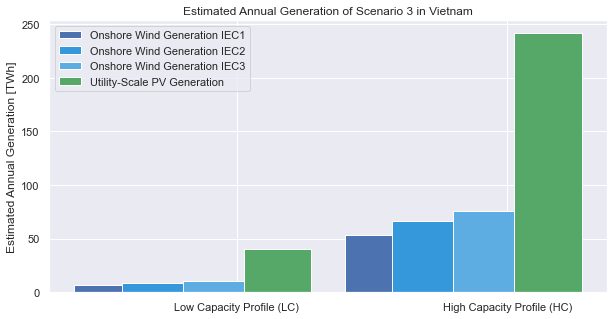

In [38]:
y_pos = np.arange(len(cap_arr))
# wind class IEC1-3 needs to be separated
wt_gen1_arr = [wt_ag_cf1_lc, wt_ag_cf1_hc]
wt_gen2_arr = [wt_ag_cf2_lc, wt_ag_cf2_hc]
wt_gen3_arr = [wt_ag_cf3_lc, wt_ag_cf3_hc]
pv_gen_arr = [pv_ag_lc, pv_ag_hc]
bar_width = 0.35

sns.set(rc={'figure.figsize':(10,5)})
wt1_rects = plt.bar(y_pos - 0.45, wt_gen1_arr, width= 0.3,  color='b', label='Onshore Wind Generation IEC1')
wt2_rects = plt.bar(y_pos - 0.3, wt_gen2_arr, width= 0.25,  color='#3498DB', label='Onshore Wind Generation IEC2')
wt3_rects = plt.bar(y_pos - 0.05, wt_gen3_arr, width= 0.3,  color='#5DADE2', label='Onshore Wind Generation IEC3')
pv_rects = plt.bar(y_pos + 0.15, pv_cap_arr, width=0.25,  color='g', label='Utility-Scale PV Generation')
plt.xticks(y_pos, cap_arr)
plt.ylabel('Estimated Annual Generation [TWh]')
plt.title('Estimated Annual Generation of Scenario 3 in Vietnam')
plt.savefig(r'Vietnam/03_output_stage3/03_generation_scenario3_method1.tiff',bbox_inches='tight', dpi=300)
plt.legend()
plt.show()

## 4. Method 2: Calculate the potentials capacity & annual generation via average hourly generation from 4 different cities
(a) whole country<br>
(b) Regional division (under development) <br>
*hourly generation of one onshore wind turbine and one pv panel are used from 4 different cities in Vietnam (Hanoi, Vinh, Da Nang, and Ho Chi Minh)<br>
**The analysis divides the available land areas (scenario 3 from stage 2) into 50% for utility solar PV and 50% for onshore wind farm planning.**

### a. Calculate the hourly data of wind and solar resources

In [59]:
%%time
m2_wt_sort_df = wt_fileOne_df.copy()
m2_wt_sort_df = time_sort(m2_wt_sort_df)

wt_75mw_df = pd.DataFrame(columns=['time','year', 'month', 'day', 'hour', 'hourly_generation[kWh]'])
wt_2mw_df = pd.DataFrame(columns=['time','year', 'month', 'day', 'hour', 'hourly_generation[kWh]'])
wt_75mw_df = method2_gen(wt_75mw_df, m2_wt_sort_df, 7.5)
wt_2mw_df = method2_gen(wt_2mw_df, m2_wt_sort_df, 2)
wt_75mw_df = wt_75mw_df.dropna()
wt_2mw_df = wt_2mw_df.dropna()

# convert unit from MW/w to TWh
wt_75mw_df['hourly_generation[kWh]'] = (wt_75mw_df['hourly_generation[kWh]'])/(10**9)
wt_2mw_df['hourly_generation[kWh]'] = (wt_2mw_df['hourly_generation[kWh]'])/(10**9)
wt_75mw_df.rename(columns={'hourly_generation[kWh]': "hourly_wind_generation[TWh]"}, inplace = True)
wt_2mw_df.rename(columns={'hourly_generation[kWh]': "hourly_wind_generation[TWh]" }, inplace = True)

Wall time: 1min 38s


In [61]:
%%time
m2_pv_sort_df = pv_fileOne_df.copy()
m2_pv_sort_df = time_sort(m2_pv_sort_df)

pv_600w_df = pd.DataFrame(columns=['time','year', 'month', 'day', 'hour', 'hourly_generation[kWh]'])
pv_250w_df = pd.DataFrame(columns=['time','year', 'month', 'day', 'hour', 'hourly_generation[kWh]'])
pv_600w_df = method2_gen(pv_600w_df, m2_pv_sort_df, 600)
pv_250w_df = method2_gen(pv_250w_df, m2_pv_sort_df, 250)
pv_600w_df = pv_600w_df.dropna()
pv_250w_df = pv_250w_df.dropna()

# convert unit from MW/w to TWh
pv_600w_df['hourly_generation[kWh]'] = (pv_600w_df['hourly_generation[kWh]'])/10**9
pv_250w_df['hourly_generation[kWh]'] = (pv_250w_df['hourly_generation[kWh]'])/10**9
pv_600w_df.rename(columns={'hourly_generation[kWh]': "hourly_pv_generation[TWh]" }, inplace = True)
pv_250w_df.rename(columns={'hourly_generation[kWh]': "hourly_pv_generation[TWh]" }, inplace = True)

Wall time: 1min 48s


### b. Calculate Wind potential capacity and annual generation

Wind Turbine selection: <br>
1. Enercon E-126 7500 (7.5 MW) <br>
Reference: https://www.enercon.de/en/products/ep-8/e-126/ <br>
Diameter: 127m <br>
Hub Height: 100m <br>
2. Vestas V90 2MW (2 MW) <br>
Reference: https://en.wind-turbine-models.com/turbines/16-vestas-v90 <br>
Diameter: 90m <br>
Hub Height: 105m <br>

In [80]:
# wind turbine assumption
wt_p75_2 = 7.5 # rated power 7.5MW , 2MW
wt_p2_2 = 2
r_dia75_2 = 0.127 # rotor diameter 127m, 105m
r_dia2_2 = 0.105
wt_d75_2 = 4*r_dia75_2*4*r_dia75_2 # distance between wind turbine: L*W = (4*rotor diameter)*(4*rotor diameter) (km2)
wt_d2_2 = 4*r_dia2_2*4*r_dia2_2
wd_amount75_2 = land_sum*wt_sh / wt_d75_2 # total amount of wind turbines that can be installed on available land
wd_amount2_2 = land_sum*wt_sh / wt_d2_2

In [81]:
# wind turbine calculation
wt_75mw_df['number_of_wind_turbines[pc]'] = wd_amount75_2.astype(int)
wt_2mw_df['number_of_wind_turbines[pc]'] = wd_amount2_2.astype(int)
wt_75mw_df['hourly_wind_generation_sum[TWh]'] = (wt_75mw_df['hourly_wind_generation[TWh]'])*wd_amount75_2
wt_2mw_df['hourly_wind_generation_sum[TWh]'] = (wt_2mw_df['hourly_wind_generation[TWh]'])*wd_amount2_2

wd_2_cp75 = wd_amount75_2*wt_p75_2/10**3 # total installed capacity of all wind turbines (GW)
wd_2_cp2 = wd_amount2_2*wt_p2_2/10**3

wd_2_sum75 = wt_75mw_df['hourly_wind_generation_sum[TWh]'].sum(axis = 0, skipna = True) # annual total geneartion of all wind turbines (TWh)
wd_2_sum2 = wt_2mw_df['hourly_wind_generation_sum[TWh]'].sum(axis = 0, skipna = True)

wd_2_cf75 = wd_2_sum75*10**3/(wd_2_cp75*8760) # capacity factor
wd_2_cf2 = wd_2_sum2*10**3/(wd_2_cp2*8760)

# Save csv file of annual total wind geneartion
wt_75mw_df.to_csv(r'Vietnam/03_output_stage3/03_vn_annual_hourly_wind_generation_wind_turbine_75mw_method2.csv', index = True)
wt_2mw_df.to_csv(r'Vietnam/03_output_stage3/03_vn_annual_hourly_wind_generation_wind_turbine_2mw_method2.csv', index = True)

print('Method 3 Estimated Hourly Generation',
      '\nOnshore windfarm potential capacity of scenario 2 in', name, ':', 
      '\n (1) Wind Turbine 7.5 MW', wd_2_cp75, 'GW',
      '\n (2) Wind Turbine 2 MW', wd_2_cp2, 'GW',
      '\nOnshore windfarm estimated annual generation of scenario 2 in', name, ':', 
      '\n (1) Wind Turbine 7.5 MW', wd_2_sum75, 'TWh',
      '\n (2) Wind Turbine 2 MW', wd_2_sum2, 'TWh',
      '\nOnshore windfarm capacity factor of scenario 2 in', name, ':', 
      '\n (1) Wind Turbine 7.5 MW', wd_2_cf75,
      '\n (2) Wind Turbine 2 MW', wd_2_cf2)

Method 3 Estimated Hourly Generation 
Onshore windfarm potential capacity of scenario 2 in Vietnam : 
 (1) Wind Turbine 7.5 MW 23.384421868485802 GW 
 (2) Wind Turbine 2 MW 9.122717226105703 GW 
Onshore windfarm estimated annual generation of scenario 2 in Vietnam : 
 (1) Wind Turbine 7.5 MW 22.084920561042622 TWh 
 (2) Wind Turbine 2 MW 14.386589352216646 TWh 
Onshore windfarm capacity factor of scenario 2 in Vietnam : 
 (1) Wind Turbine 7.5 MW 0.10781150234398783 
 (2) Wind Turbine 2 MW 0.1800236354880137


### c. Calculate Solar PV potential capacity & annual generation (tilt angle 35 degree)

PV Panel selection:
1. Canadian SolarHiKu7 (600W) <br>
Reference: https://testsolar.csisolar.com/wp-content/uploads/2020/10/Canadian_Solar-Flyer-HiKu7_CS7L-MS_EN.pdf <br>
Rated Power: 600 W Solar Panel<br>
Efficiency: 21.2 % <br>
Size: 2172 x 1303 x 35 mm<br>
2. Centsys 250W (250W) <br>
Reference: https://www.centsys.com.au/pdf/Solar/0.07.B.0133%20250W%20Solar%20Panel%20Specifications%20sheet-29062015-NG.pdf <br>
Rated Power: 250 W Solar Panel<br>
Efficiency: 17.2 % <br>
Size: 1650 x 992 x 40 mm<br>

In [82]:
# PV assumption
dim_p6_2 = 2172*1303 # dimension: 2172x1303x35 mm/ 1650x992x40mm
dim_p25_2 = 1650*992
pv_p6_2 = 600 # rated power 600Wp / 250Wp
pv_p25_2 = 250
pv_ef6_2 = 0.212 # efficiency factor of the PV modules: 21.2 (%) / 17.2 (%)
pv_ef25_2 = 0.172
pv_amount6_2 = land_sum*pv_sh / (dim_p6_2/10**12) # total amount of pv that can be installed on available land
pv_amount25_2 = land_sum*pv_sh / (dim_p25_2/10**12)

In [83]:
# PV calculation
pv_600w_df['number_of_pv[pc]'] = pv_amount6_2.astype(int)
pv_250w_df['number_of_pv[pc]'] = pv_amount25_2.astype(int)
pv_600w_df['hourly_pv_generation_sum[TWh]'] = (pv_600w_df['hourly_pv_generation[TWh]'])*pv_amount6_2 
pv_250w_df['hourly_pv_generation_sum[TWh]'] = (pv_250w_df['hourly_pv_generation[TWh]'])*pv_amount25_2

pv_2_cp6 = pv_amount6_2*pv_p6_2/10**9 # total installed capacity of all pv (GW)
pv_2_cp25 = pv_amount25_2*pv_p25_2/10**9

pv_2_sum6 = pv_600w_df['hourly_pv_generation_sum[TWh]'].sum(axis = 0, skipna = True) #  annual total geneartion of all pvs (GW)
pv_2_sum25 = pv_250w_df['hourly_pv_generation_sum[TWh]'].sum(axis = 0, skipna = True)

pv_2_cf6 = pv_2_sum6*10**3/(pv_2_cp6*8760) # capacity factor 
pv_2_cf25 = pv_2_sum25*10**3/(pv_2_cp25*8760)

# Save csv file of annual total solar geneartion
pv_600w_df.to_csv(r'Vietnam/03_output_stage3/03_vn_annual_hourly_pv_generation_pv_panel_600w_method2.csv', index = True)
pv_250w_df.to_csv(r'Vietnam/03_output_stage3/03_vn_annual_hourly_pv_generation_pv_panel_250w_method2.csv', index = True)

print('Method 3 Estimated Hourly Generation',
      '\nUtility-Scale PV potential capacity of scenario 2 in', name, ':', 
      '\n (1) PV 600W:', pv_2_cp6, 'GW',
      '\n (2) PV 250W:', pv_2_cp25, 'GW',
      '\nUtility-Scale PV estimated annual generation of scenario 2 in', name, ':', 
      '\n (1) PV 600W:', pv_2_sum6, 'TWh',
      '\n (2) PV 250W:', pv_2_sum25, 'TWh',
      '\nUtility-Scale PV capacity factor of scenario 2 in', name, ':', 
      '\n (1) PV 600W:', pv_2_cf6,
      '\n (2) PV 250W:', pv_2_cf25)

Method 3 Estimated Hourly Generation 
Utility-Scale PV potential capacity of scenario 2 in Vietnam : 
 (1) PV 600W: 170.5845963930502 GW 
 (2) PV 250W: 122.89584239713508 GW 
Utility-Scale PV estimated annual generation of scenario 2 in Vietnam : 
 (1) PV 600W: 232.51064303714628 TWh 
 (2) PV 250W: 167.51477562536616 TWh 
Utility-Scale PV capacity factor of scenario 2 in Vietnam : 
 (1) PV 600W: 0.15559617579908677 
 (2) PV 250W: 0.15560079908675803


## 6. Comparison of different methods

### a. Utility PV

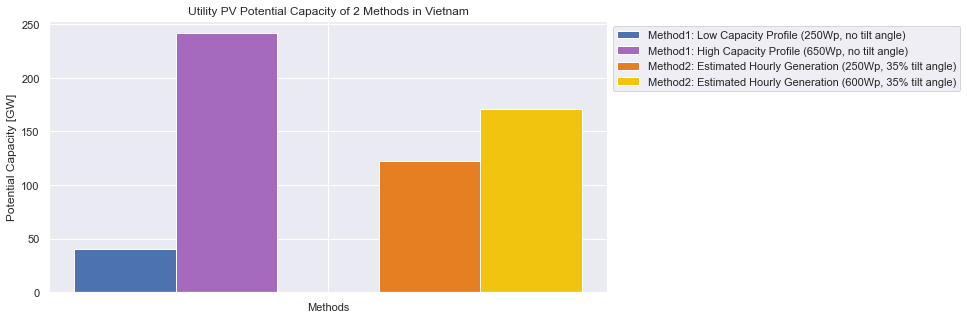

In [86]:
# Potential Capacity
method_arr = ['Methods']
y_pos = np.arange(1)
bar_width = 0.35

sns.set(rc={'figure.figsize':(10,5)})
m1_pvlc_rects = plt.bar(y_pos - 0.4, pv_pc_lc, width= 0.2,  color='b', label='Method1: Low Capacity Profile (250Wp, no tilt angle)')
m1_pvhc_rects = plt.bar(y_pos - 0.2, pv_pc_hc, width=0.2,  color='#A569BD', label='Method1: High Capacity Profile (650Wp, no tilt angle)')
m2_pv25_rects = plt.bar(y_pos + 0.2, pv_2_cp25, width=0.2,  color='#E67E22', label='Method2: Estimated Hourly Generation (250Wp, 35% tilt angle)')
m2_pv6_rects = plt.bar(y_pos + 0.4, pv_2_cp6, width=0.2,  color='#F1C40F', label='Method2: Estimated Hourly Generation (600Wp, 35% tilt angle)')
plt.xticks(y_pos, method_arr)
plt.ylabel('Potential Capacity [GW]')
plt.title('Utility PV Potential Capacity of 2 Methods in Vietnam')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.savefig(r'Vietnam/03_output_stage3/03_pv_potential_capacity_comparison.tiff',bbox_inches='tight', dpi=300)
plt.show()

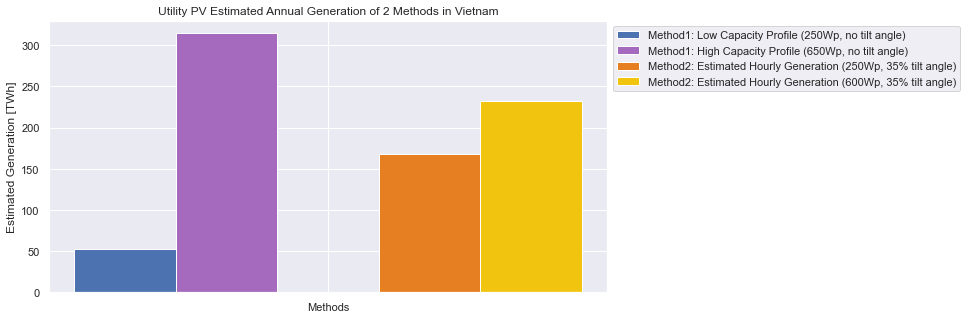

In [87]:
# Annual Generation
method_arr = ['Methods']
y_pos = np.arange(1)
#method1_arr = [pv_pc_lc, wt_pc_hc]
#method2_arr = [pv_pc_lc, pv_pc_hc]
#method3_arr = [pv_pc_lc, pv_pc_hc]
bar_width = 0.35

sns.set(rc={'figure.figsize':(10,5)})
m1_pvlc_rects = plt.bar(y_pos - 0.4, pv_ag_lc, width= 0.2,  color='b', label='Method1: Low Capacity Profile (250Wp, no tilt angle)')
m1_pvhc_rects = plt.bar(y_pos - 0.2, pv_ag_hc, width=0.2,  color='#A569BD', label='Method1: High Capacity Profile (650Wp, no tilt angle)')
m2_pv25_rects = plt.bar(y_pos + 0.2, pv_2_sum25, width=0.2,  color='#E67E22', label='Method2: Estimated Hourly Generation (250Wp, 35% tilt angle)')
m2_pv6_rects = plt.bar(y_pos + 0.4, pv_2_sum6, width=0.2,  color='#F1C40F', label='Method2: Estimated Hourly Generation (600Wp, 35% tilt angle)')
plt.xticks(y_pos, method_arr)
plt.ylabel('Estimated Generation [TWh]')
plt.title('Utility PV Estimated Annual Generation of 2 Methods in Vietnam')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.savefig(r'Vietnam/03_output_stage3/03_pv_annual_generation_comparison.tiff',bbox_inches='tight', dpi=300)
plt.show()

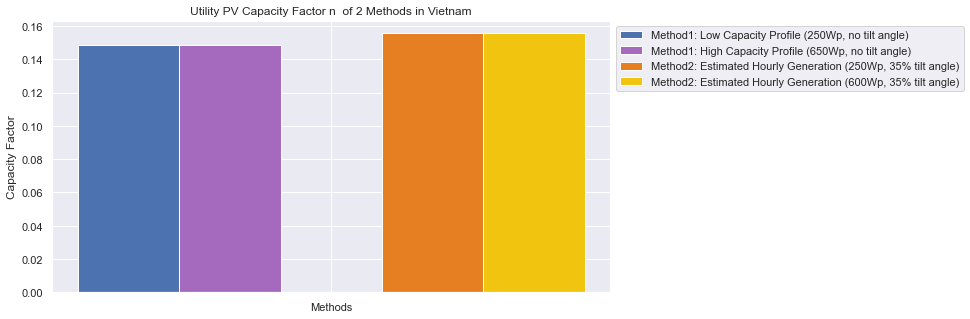

In [88]:
# Capacity Factor
method_arr = ['Methods']
y_pos = np.arange(1)
#method1_arr = [pv_pc_lc, wt_pc_hc]
#method2_arr = [pv_pc_lc, pv_pc_hc]
#method3_arr = [pv_pc_lc, pv_pc_hc]
bar_width = 0.35

sns.set(rc={'figure.figsize':(10,5)})
m1_pvlc_rects = plt.bar(y_pos - 0.4, pv_ag_lc_cf, width= 0.2,  color='b', label='Method1: Low Capacity Profile (250Wp, no tilt angle)')
m1_pvhc_rects = plt.bar(y_pos - 0.2, pv_ag_hc_cf, width=0.2,  color='#A569BD', label='Method1: High Capacity Profile (650Wp, no tilt angle)')
m2_pv25_rects = plt.bar(y_pos + 0.2, pv_2_cf25, width=0.2,  color='#E67E22', label='Method2: Estimated Hourly Generation (250Wp, 35% tilt angle)')
m2_pv6_rects = plt.bar(y_pos + 0.4, pv_2_cf6, width=0.2,  color='#F1C40F', label='Method2: Estimated Hourly Generation (600Wp, 35% tilt angle)')
plt.xticks(y_pos, method_arr)
plt.ylabel('Capacity Factor')
plt.title('Utility PV Capacity Factor n  of 2 Methods in Vietnam')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.savefig(r'Vietnam/03_output_stage3/03_pv_capacity_factor_comparison.tiff',bbox_inches='tight', dpi=300)
plt.show()

### b. OnShore Wind Turbine

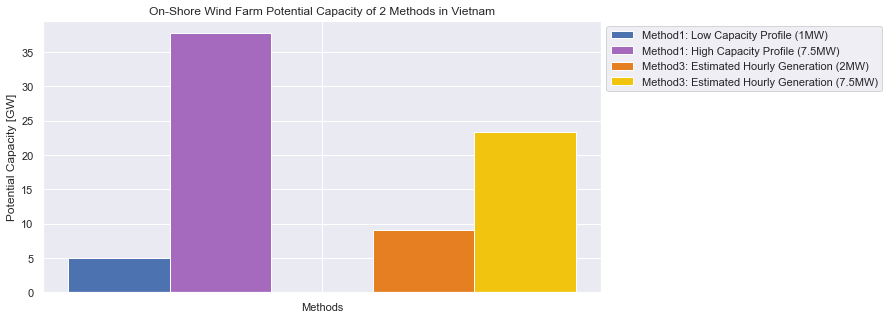

In [89]:
# Potential Capacity
sns.set(rc={'figure.figsize':(10,5)})
m1_pvlc_rects = plt.bar(y_pos - 0.4, wt_pc_lc, width= 0.2,  color='b', label='Method1: Low Capacity Profile (1MW)')
m1_pvhc_rects = plt.bar(y_pos - 0.2, wt_pc_hc, width=0.2,  color='#A569BD', label='Method1: High Capacity Profile (7.5MW)')
m2_pv25_rects = plt.bar(y_pos + 0.2, wd_2_cp2, width=0.2,  color='#E67E22', label='Method3: Estimated Hourly Generation (2MW)')
m2_pv6_rects = plt.bar(y_pos + 0.4, wd_2_cp75, width=0.2,  color='#F1C40F', label='Method3: Estimated Hourly Generation (7.5MW)')
plt.xticks(y_pos, method_arr)
plt.ylabel('Potential Capacity [GW]')
plt.title('On-Shore Wind Farm Potential Capacity of 2 Methods in Vietnam')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.savefig(r'Vietnam/03_output_stage3/03_wind_potential_capacity_comparison.tiff',bbox_inches='tight', dpi=300)
plt.show()

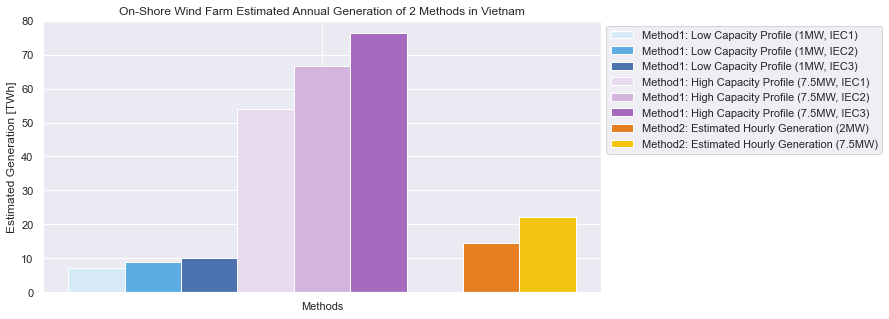

In [90]:
# Annual Generation
sns.set(rc={'figure.figsize':(10,5)})
m1_pvlc_rects = plt.bar(y_pos - 0.8, wt_ag_cf1_lc, width= 0.2,  color='#D6EAF8', label='Method1: Low Capacity Profile (1MW, IEC1)')
m1_pvlc_rects = plt.bar(y_pos - 0.6, wt_ag_cf2_lc, width= 0.2,  color='#5DADE2', label='Method1: Low Capacity Profile (1MW, IEC2)')
m1_pvlc_rects = plt.bar(y_pos - 0.4, wt_ag_cf3_lc, width= 0.2,  color='b', label='Method1: Low Capacity Profile (1MW, IEC3)')
m1_pvhc_rects = plt.bar(y_pos - 0.2, wt_ag_cf1_hc, width=0.2,  color='#E8DAEF', label='Method1: High Capacity Profile (7.5MW, IEC1)')
m1_pvhc_rects = plt.bar(y_pos, wt_ag_cf2_hc, width=0.2,  color='#D2B4DE', label='Method1: High Capacity Profile (7.5MW, IEC2)')
m1_pvhc_rects = plt.bar(y_pos + 0.2, wt_ag_cf3_hc, width=0.2,  color='#A569BD', label='Method1: High Capacity Profile (7.5MW, IEC3)')
m2_pv25_rects = plt.bar(y_pos + 0.6, wd_2_sum2, width=0.2,  color='#E67E22', label='Method2: Estimated Hourly Generation (2MW)')
m2_pv6_rects = plt.bar(y_pos + 0.8, wd_2_sum75, width=0.2,  color='#F1C40F', label='Method2: Estimated Hourly Generation (7.5MW)')
plt.xticks(y_pos, method_arr)
plt.ylabel('Estimated Generation [TWh]')
plt.title('On-Shore Wind Farm Estimated Annual Generation of 2 Methods in Vietnam')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.savefig(r'Vietnam/03_output_stage3/03_wind_annual_generation_comparison.tiff',bbox_inches='tight', dpi=300)
plt.show()

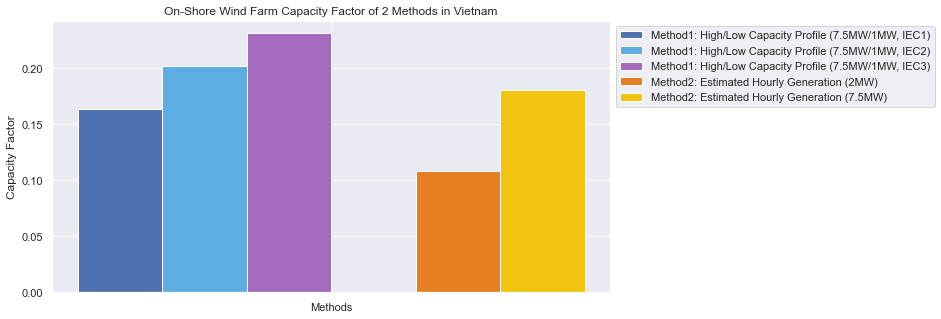

In [91]:
# Capacity Factor
sns.set(rc={'figure.figsize':(10,5)})
m1_pvlc_rects = plt.bar(y_pos - 0.5, wt_cf1_sum, width= 0.2,  color='b', label='Method1: High/Low Capacity Profile (7.5MW/1MW, IEC1)')
m1_pvlc_rects = plt.bar(y_pos - 0.3, wt_cf2_sum, width= 0.2,  color='#5DADE2', label='Method1: High/Low Capacity Profile (7.5MW/1MW, IEC2)')
m1_pvhc_rects = plt.bar(y_pos - 0.1, wt_cf3_sum, width=0.2,  color='#A569BD', label='Method1: High/Low Capacity Profile (7.5MW/1MW, IEC3)')
m2_pv25_rects = plt.bar(y_pos + 0.3, wd_2_cf75, width=0.2,  color='#E67E22', label='Method2: Estimated Hourly Generation (2MW)')
m2_pv6_rects = plt.bar(y_pos + 0.5, wd_2_cf2, width=0.2,  color='#F1C40F', label='Method2: Estimated Hourly Generation (7.5MW)')
plt.xticks(y_pos, method_arr)
plt.ylabel('Capacity Factor')
plt.title('On-Shore Wind Farm Capacity Factor of 2 Methods in Vietnam')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.savefig(r'Vietnam/03_output_stage3/03_wind_capacity_factor_comparison.tiff',bbox_inches='tight', dpi=300)
plt.show()